In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
# Modelling Libraries
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation & CV Libraries
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
df=pd.read_csv('flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non-null  float64
 13  WHEELS_OFF           5730032 non-null  float64
 14  SCHEDULED_TIME       5819073 non-null  float64
 15

### The main goal of this project is to predict arrival delay

In [5]:
# I remove Nans from columns where flights were cancelled (or diverted)
df.dropna(subset=['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 
                'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY'], inplace=True)
# I remove columns 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'
df.drop(['DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'], axis=1, inplace=True)
# I remove columns with insufficient data
df.drop(["AIR_SYSTEM_DELAY","SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"], axis=1, inplace=True)

In [6]:
# In the initial dataframe, dates are coded according to 4 variables: YEAR, MONTH, DAY, and DAY_OF_WEEK. 
# I change it into datetime format:
import datetime
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])
# I'll need name of the week and month name
df['DAY_NAME'] = df['DATE'].dt.day_name()
df['MONTH_NAME'] = df['DATE'].dt.month_name()
# I remove those 4 unnecessary columns
df.drop(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK'], axis=1, inplace=True)

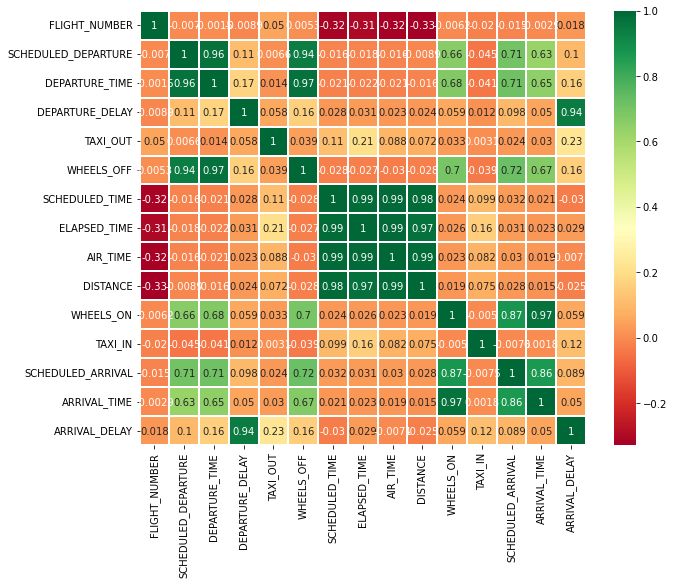

In [7]:
corr=df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.05)
plt.show()

#### Departure_delay column is the most correlated data with arrival_delay, but I want to predict arrival delays before the flight.

In [8]:
# My goal is to predict if the arrival will be delayed or not, that's why I removed columns that have nothing to do with the goal:
df.drop(['FLIGHT_NUMBER', 'TAIL_NUMBER', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'DEPARTURE_DELAY', 'DEPARTURE_TIME',
             'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME'], axis=1, inplace=True)

In [9]:
df.sample(10)

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DATE,DAY_NAME,MONTH_NAME
3754663,WN,SMF,ONT,1455,75.0,390,1610,7.0,2015-08-21,Friday,August
2938592,UA,IAH,SJU,2359,273.0,2007,532,-8.0,2015-07-03,Friday,July
1437438,NK,ORD,FLL,530,181.0,1182,931,-4.0,2015-04-03,Friday,April
1018951,MQ,DFW,BRO,1405,95.0,482,1540,2.0,2015-03-08,Sunday,March
2693759,DL,ATL,FLL,1000,115.0,581,1155,16.0,2015-06-19,Friday,June
3999656,EV,GPT,IAH,635,88.0,376,803,-20.0,2015-09-06,Sunday,September
2861389,US,PIT,CLT,1030,90.0,366,1200,3.0,2015-06-29,Monday,June
4153710,UA,IAH,MCO,900,145.0,854,1225,-4.0,2015-09-16,Wednesday,September
1185527,B6,PVD,MCO,1609,179.0,1072,1908,25.0,2015-03-18,Wednesday,March
3107365,AA,DCA,FLL,830,156.0,899,1106,-11.0,2015-07-14,Tuesday,July


In [10]:
# SCHEDULED_DEPARTURE and _ARRIVAL - this columns shows hours and minutes from departures and arrivals
# I'm changing it into full hours
df['SCHEDULED_DEPARTURE_H'] = df['SCHEDULED_DEPARTURE'] // 100
df['SCHEDULED_ARRIVAL_H'] = df['SCHEDULED_ARRIVAL'] // 100
# Remove column SCHEDULED_DEPARTURE:
df.drop(['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], axis=1, inplace=True)

# In the data there was one position with hour = 24 (should be 00)
df['SCHEDULED_ARRIVAL_H'].replace(24, 0, inplace=True)

## An additional file of this dataset, the airports.csv file, gives a more exhaustive description of the airports:

In [11]:
airports=pd.read_csv('airports.csv')
airports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [12]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [13]:
# Chcking the Nan values
airports[airports['LATITUDE'].isna()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


In [14]:
# taking real world data for missing values:
airports.loc[234,'LATITUDE'] = 44.3903
airports.loc[234,'LONGITUDE']= -73.2805
airports.loc[96,'LATITUDE'] = 30.2130
airports.loc[96,'LONGITUDE']= -85.4744
airports.loc[313,'LATITUDE'] = 29.57333
airports.loc[313,'LONGITUDE']= -81.2023

In [15]:
# In airports.csv we have airports only from one country - USA
airports['COUNTRY'].value_counts()

USA    322
Name: COUNTRY, dtype: int64

In [16]:
# In airports.csv we have airports from 54 states of USA
airports['STATE'].unique().shape

(54,)

In [17]:
# In the dataframe there are also airports that are not in the airport.csv file
df['ORIGIN_AIRPORT'].value_counts()

ATL      343506
ORD      276554
DFW      232647
DEN      193402
LAX      192003
          ...  
13541        11
10165         9
14222         9
13502         6
11503         4
Name: ORIGIN_AIRPORT, Length: 628, dtype: int64

In [18]:
# I remove the data where airports are shown in 5-digit code and create new dataframe - df_air
df_air= df[df['ORIGIN_AIRPORT'] > 'AAA']
df_air.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5231130 entries, 0 to 5819078
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   AIRLINE                5231130 non-null  object        
 1   ORIGIN_AIRPORT         5231130 non-null  object        
 2   DESTINATION_AIRPORT    5231130 non-null  object        
 3   SCHEDULED_TIME         5231130 non-null  float64       
 4   DISTANCE               5231130 non-null  int64         
 5   ARRIVAL_DELAY          5231130 non-null  float64       
 6   DATE                   5231130 non-null  datetime64[ns]
 7   DAY_NAME               5231130 non-null  object        
 8   MONTH_NAME             5231130 non-null  object        
 9   SCHEDULED_DEPARTURE_H  5231130 non-null  int64         
 10  SCHEDULED_ARRIVAL_H    5231130 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 478.9+ MB


## An additional file of this dataset, the airlines.csv file, gives a more exhaustive description of the airlines:

In [19]:
airlines_names=pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


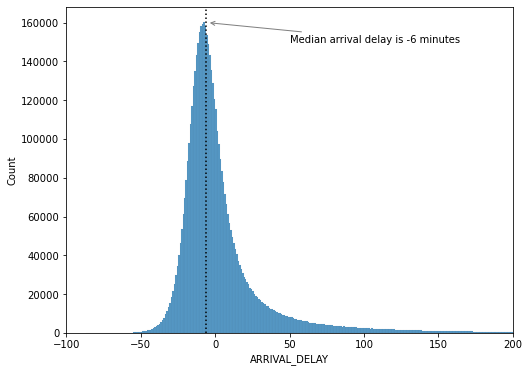

In [20]:
plt.figure(figsize=(8,6))
ax = sns.histplot(x='ARRIVAL_DELAY', data=df_air, binwidth=1)
ax.axvline(x=-6, linestyle='dotted', color='black')
ax.annotate('Median arrival delay is -6 minutes', xy=[-5,160000], 
           xytext=[50, 150000],
           arrowprops={'arrowstyle': '->', 'color':'gray'})
plt.xlim(-100, 200)
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_3544\2779006224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air.loc[df_air["ARRIVAL_DELAY"] >= 0, "delayed"] = 1


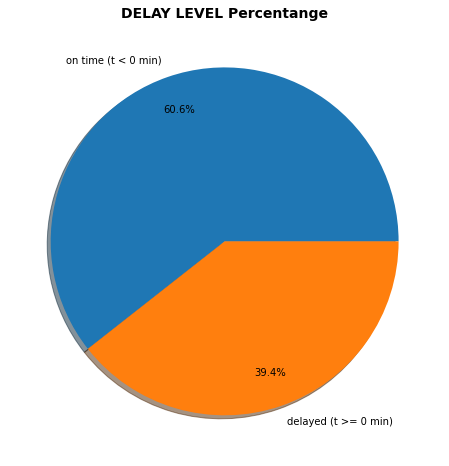

In [21]:
# Function that define how delays are grouped
df_air.loc[df_air["ARRIVAL_DELAY"] >= 0, "delayed"] = 1
df_air.loc[df_air["ARRIVAL_DELAY"] < 0, "delayed"] = 0

# Pie chart to show how many
delay_level = dict(df_air.groupby('delayed')['delayed'].count())
labels = ['on time (t < 0 min)', 'delayed (t >= 0 min)']
values = delay_level.values()
plt.figure(figsize=(8,8))
plt.pie(data=df_air, x=values, labels= labels, autopct = '%1.1f%%', pctdistance=0.8, shadow=True)
plt.title('DELAY LEVEL Percentange', fontsize=14, weight = 'bold')
plt.show()

In [22]:
# I create a dictionary with IATA_CODE and AIRLINE name
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

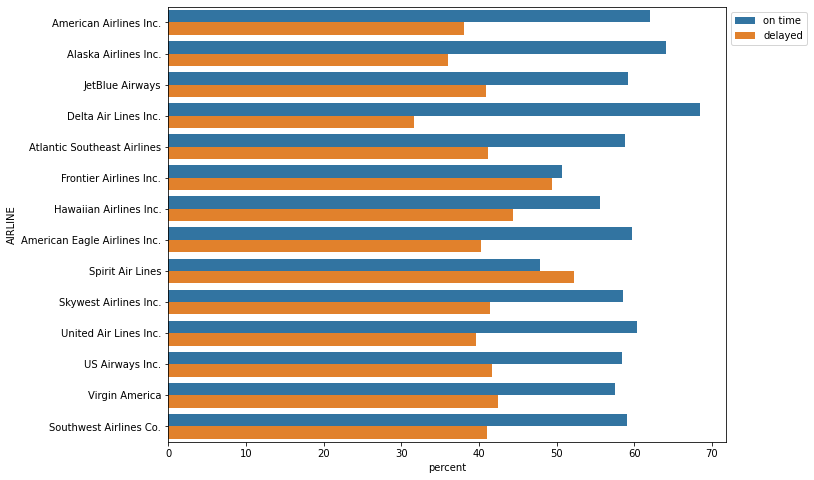

In [23]:
df1 = df_air.groupby('AIRLINE')['delayed'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
df1['AIRLINE'] = df1['AIRLINE'].replace(abbr_companies)

plt.figure(figsize=(10,8))
sns.barplot(y='AIRLINE', x='percent', hue='delayed', data=df1)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time')
L.get_texts()[1].set_text('delayed') 
plt.show()

## Time charts

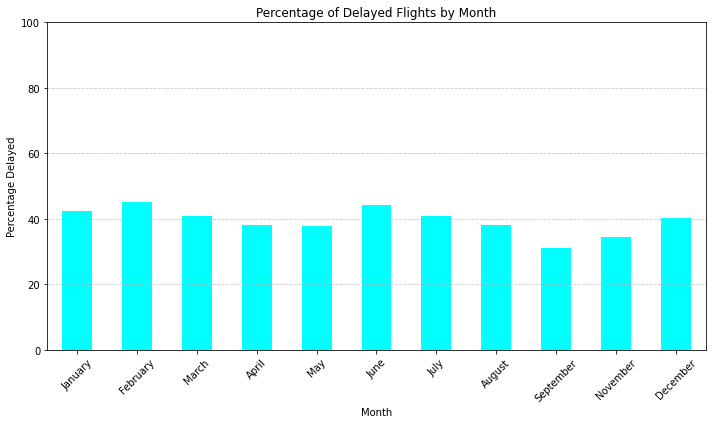

In [39]:
# Calculate the percentage of delayed flights for each month
delayed_percentage = df_air.groupby('MONTH_NAME')['delayed'].mean() * 100

# set month order
month_order = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Sort the percentage data based on the integer values of months
delayed_percentage_sorted = delayed_percentage.reset_index()
delayed_percentage_sorted['MONTH_NAME'] = delayed_percentage_sorted['MONTH_NAME'].map(month_order)
delayed_percentage_sorted = delayed_percentage_sorted.sort_values(by='MONTH_NAME')
delayed_percentage_sorted['MONTH_NAME'] = delayed_percentage_sorted['MONTH_NAME'].map({v: k for k, v in month_order.items()})

# Create a bar plot
plt.figure(figsize=(10, 6))
delayed_percentage.plot(kind='bar', color='cyan')
plt.title('Percentage of Delayed Flights by Month')
plt.xlabel('Month')
plt.ylabel('Percentage Delayed')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

    the less delays are in September

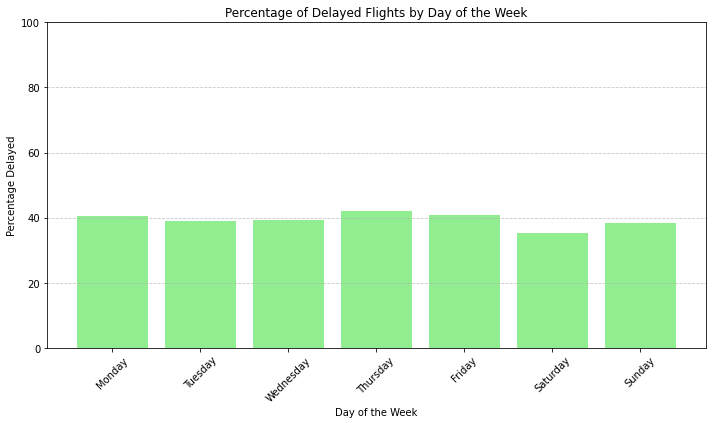

In [41]:
# Calculate the percentage of delayed flights for each day of the week
delayed_percentage_day = df_air.groupby('DAY_NAME')['delayed'].mean() * 100

# Create a mapping of day names to their corresponding integer values
day_order = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

# Sort the percentage data based on the integer values of days
delayed_percentage_day_sorted = delayed_percentage_day.reset_index()
delayed_percentage_day_sorted['DAY_NAME'] = delayed_percentage_day_sorted['DAY_NAME'].map(day_order)
delayed_percentage_day_sorted = delayed_percentage_day_sorted.sort_values(by='DAY_NAME')
delayed_percentage_day_sorted['DAY_NAME'] = delayed_percentage_day_sorted['DAY_NAME'].map({v: k for k, v in day_order.items()})

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(delayed_percentage_day_sorted['DAY_NAME'], delayed_percentage_day_sorted['delayed'], color='lightgreen')
plt.title('Percentage of Delayed Flights by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Percentage Delayed')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


    the less delays are in Saturdays

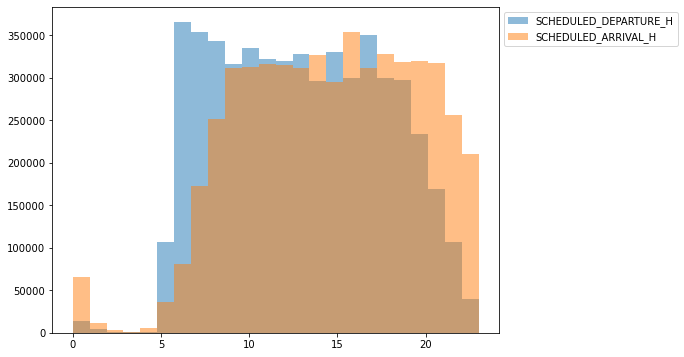

In [31]:
fig, ax=plt.subplots(figsize=(8,6))
ax.hist(df_air['SCHEDULED_DEPARTURE_H'], label='SCHEDULED_DEPARTURE_H', alpha=0.5, bins=24)
ax.hist(df_air['SCHEDULED_ARRIVAL_H'], label='SCHEDULED_ARRIVAL_H', alpha=0.5, bins=24)
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

    Typically more depatures are in the morning, and more departures are in the evening

### Delay map

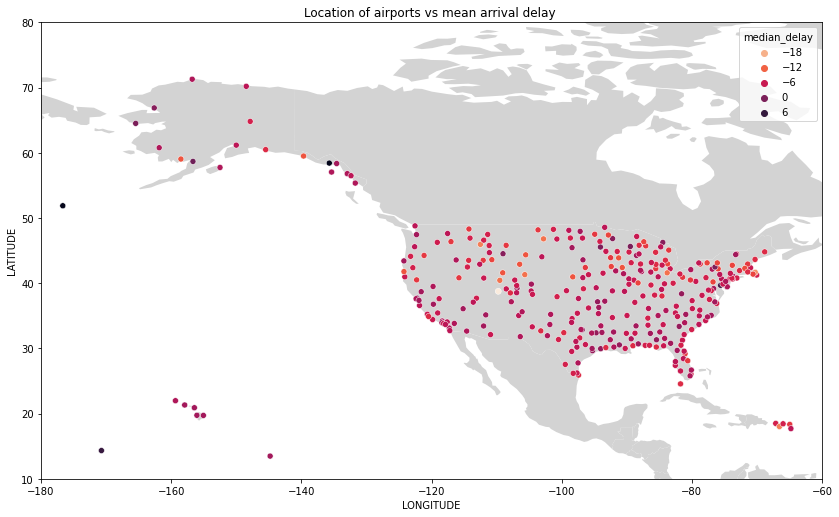

In [34]:
# Create new table with information about arrival delay and airports coordinates
df3 = df_air.loc[:, ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY']]
df4 = df3.merge(airports, how='inner', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')

# Group by origin airport to count mean arrival delay
delay_map_dep = df4.groupby('ORIGIN_AIRPORT').agg(
                    median_delay=('ARRIVAL_DELAY', 'median'), 
                    LATITUDE=('LATITUDE', 'mean'), LONGITUDE=('LONGITUDE', 'mean'))

# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(14, 9))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting our Mean_delay data with a color map
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=delay_map_dep, hue='median_delay', palette='rocket_r')
plt.title('Location of airports vs mean arrival delay ', fontsize=12)
plt.xlim([-180, -60])
plt.ylim([10, 80])
plt.show()

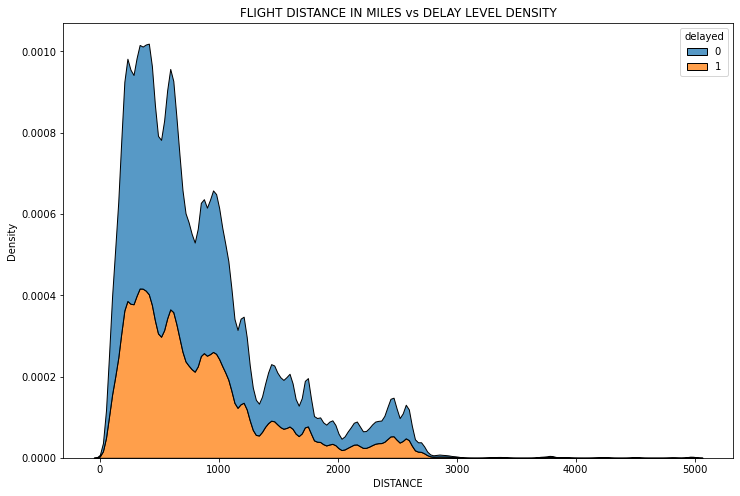

In [42]:
plt.figure(figsize=(12,8))
sns.kdeplot(x='DISTANCE', hue='delayed', data=df_air, multiple="stack")
plt.title('FLIGHT DISTANCE IN MILES vs DELAY LEVEL DENSITY', fontsize=12)
plt.show()

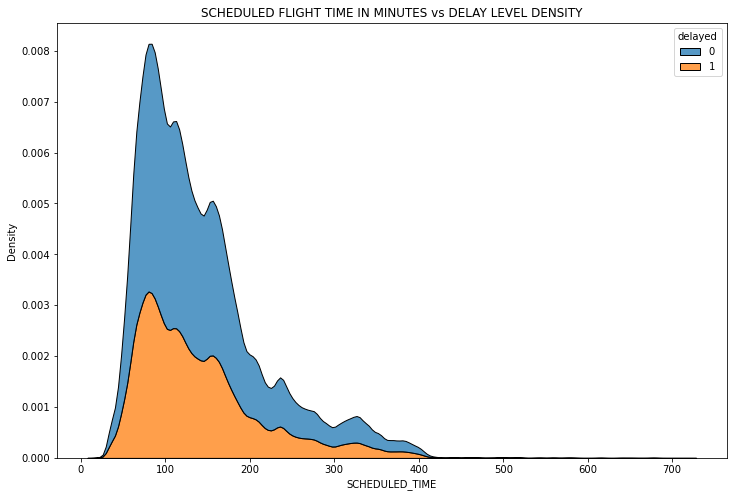

In [43]:
plt.figure(figsize=(12,8))
sns.kdeplot(x='SCHEDULED_TIME', hue='delayed', data=df_air, multiple="stack")
plt.title('SCHEDULED FLIGHT TIME IN MINUTES vs DELAY LEVEL DENSITY', fontsize=12)
plt.show()

## Model

In [55]:
# I'll use data only from January
df_1 = df_air[df_air['MONTH_NAME'] == 'January']

df_1.drop(['ARRIVAL_DELAY', 'DATE', 'MONTH_NAME'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_3544\4169140268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.drop(['ARRIVAL_DELAY', 'DATE', 'MONTH_NAME'], axis=1, inplace=True)


In [56]:
# one hot encoding
df_ohe1 = pd.get_dummies(data=df_1, columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                                             'DAY_NAME'])

In [57]:
y=df_ohe1.pop('delayed')
X=df_ohe1

# split the data into training and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [58]:
# standardizing the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
models =[("LR", LogisticRegression(random_state=1)), ('RF',RandomForestClassifier(random_state=1)),
         ("GNB", GaussianNB()), ('LGBM', LGBMClassifier(random_state=1)),
         ("XGB", XGBClassifier(random_state=1)), ("DTC", DecisionTreeClassifier()),
         ('ADA',AdaBoostClassifier(random_state=1)), ("GB",GradientBoostingClassifier(random_state=1)),
         ("RDG", RidgeClassifier())]

In [33]:
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    results_roc_auc = pd.DataFrame(columns=['Model', 'Train ROC AUC', 'Test ROC AUC'])
    results_accuracy = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])
    
    for name, model in models:
        model.fit(X_train, y_train)
        
        # Train set scores
        train_preds = model.predict(X_train)
        train_roc_auc = roc_auc_score(y_train, train_preds)
        train_accuracy = accuracy_score(y_train, train_preds)
        
        # Test set scores
        test_preds = model.predict(X_test)
        test_roc_auc = roc_auc_score(y_test, test_preds)
        test_accuracy = accuracy_score(y_test, test_preds)
        
        results_roc_auc = pd.concat([results_roc_auc, pd.DataFrame({
            'Model': [name],
            'Train ROC AUC': [train_roc_auc],
            'Test ROC AUC': [test_roc_auc]
        })], ignore_index=True)
        
        results_accuracy = pd.concat([results_accuracy, pd.DataFrame({
            'Model': [name],
            'Train Accuracy': [train_accuracy],
            'Test Accuracy': [test_accuracy]
        })], ignore_index=True)
    
    return results_roc_auc, results_accuracy

In [34]:
results_roc_auc, results_accuracy = train_and_evaluate_models(models, X_train, X_test, y_train, y_test)

In [35]:
# Print the results for roc_auc_score
print("Results for ROC AUC Score:")
print(results_roc_auc)

Results for ROC AUC Score:
  Model Train ROC AUC Test ROC AUC
0    LR      0.581505     0.580488
1    RF      0.794093     0.567524
2   GNB      0.558972     0.554485
3  LGBM      0.595402     0.592324
4   XGB      0.609197     0.597673
5   DTC      0.782548      0.55839
6   ADA      0.563277     0.567084
7    GB      0.566859     0.567986
8   RDG      0.580828     0.579542


In [36]:
# Print the results for accuracy_score
print("\nResults for Accuracy Score:")
print(results_accuracy)


Results for Accuracy Score:
  Model Train Accuracy Test Accuracy
0    LR       0.615976      0.614597
1    RF       0.803805      0.584795
2   GNB        0.54434      0.539884
3  LGBM       0.630347      0.627124
4   XGB       0.642606      0.630997
5   DTC       0.803816      0.587322
6   ADA       0.602453      0.605932
7    GB       0.611887      0.612573
8   RDG       0.615971        0.6144


    Best results for test set were for LGBM and XGBoost. I'll use Grid Search CV for hyperparameters tuning

### Deep learning model

In [50]:
# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data to 3D for LSTM input (samples, timesteps, features)
X_train = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=1)

In [51]:
model = Sequential()

# Add LSTM layers:
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
# Train the model on the training data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set and get predictions
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred = model.predict(X_test)

Epoch 1/10
9141/9141 [==============================] - 59s 6ms/step - loss: 0.6581 - accuracy: 0.6065 - val_loss: 0.6544 - val_accuracy: 0.6174
Epoch 2/10
9141/9141 [==============================] - 57s 6ms/step - loss: 0.6463 - accuracy: 0.6232 - val_loss: 0.6487 - val_accuracy: 0.6210
Epoch 3/10
9141/9141 [==============================] - 57s 6ms/step - loss: 0.6391 - accuracy: 0.6320 - val_loss: 0.6481 - val_accuracy: 0.6225
Epoch 4/10
9141/9141 [==============================] - 55s 6ms/step - loss: 0.6336 - accuracy: 0.6375 - val_loss: 0.6464 - val_accuracy: 0.6251
Epoch 5/10
9141/9141 [==============================] - 57s 6ms/step - loss: 0.6291 - accuracy: 0.6422 - val_loss: 0.6475 - val_accuracy: 0.6248
Epoch 6/10
9141/9141 [==============================] - 56s 6ms/step - loss: 0.6252 - accuracy: 0.6448 - val_loss: 0.6490 - val_accuracy: 0.6239
Epoch 7/10
9141/9141 [==============================] - 57s 6ms/step - loss: 0.6216 - accuracy: 0.6480 - val_loss: 0.6512 - val_ac

    Test accuracy for sequential model is a liitle bit lower than for XGB and LGBM

## Hyperparameters tuning

In [61]:
# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=1)

# Hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
}

# Perform RandomizedSearchCV for hyperparameter tuning
xgb_random_search = RandomizedSearchCV(xgb_model, 
                                       param_distributions=param_grid, 
                                       n_iter=10, 
                                       cv=5, 
                                       scoring='roc_auc', 
                                       random_state=1,
                                      verbose=1)

xgb_random_search.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_xgb_params = xgb_random_search.best_params_
best_xgb_model = xgb_random_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_xgb_model.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred)

print("Best XGBoost Hyperparameters:", best_xgb_params)
print("XGBoost Test ROC AUC:", test_roc_auc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGBoost Hyperparameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
XGBoost Test ROC AUC: 0.600821288952876


In [71]:
# Evaluate the best model on the test set
y_pred = best_xgb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("XGBoost Test accuracy:", test_accuracy)

XGBoost Test accuracy: 0.6339288644792841


In [72]:
# Create the LGBM classifier
lgbm_model = LGBMClassifier(random_state=1, class_weight='balanced')

# Define hyperparameter grid for LGBM
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Perform RandomizedSearchCV for hyperparameter tuning
lgbm_random_search = RandomizedSearchCV(lgbm_model, param_distributions=param_grid, 
                                        n_iter=10, cv=5, scoring='roc_auc', random_state=1)
lgbm_random_search.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_lgbm_params = lgbm_random_search.best_params_
best_lgbm_model = lgbm_random_search.best_estimator_

# Evaluate the best model on the test set
y_pred_lgbm = best_lgbm_model.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred_lgbm)
test_accuracy = accuracy_score(y_test, y_pred_lgbm)

print("Best LGBM Hyperparameters:", best_lgbm_params)
print("LGBM Test ROC AUC:", test_roc_auc)
print("LGBM Test Accuracy:", test_accuracy)

Best LGBM Hyperparameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2}
LGBM Test ROC AUC: 0.617268890642428
LGBM Test Accuracy: 0.6157018916228133


In [73]:
# Print classification report
print("Classification Report for LGBM Model:")
print(classification_report(y_test, y_pred_lgbm))

Classification Report for LGBM Model:
              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65     52731
         1.0       0.54      0.63      0.58     38672

    accuracy                           0.62     91403
   macro avg       0.61      0.62      0.61     91403
weighted avg       0.63      0.62      0.62     91403



In [74]:
# Print confusion matrix
print("Confusion Matrix for LGBM Model:")
print(confusion_matrix(y_test, y_pred_lgbm))

Confusion Matrix for LGBM Model:
[[32012 20719]
 [14407 24265]]


# Conclusions:

    - best ROC AUC score was for LGBM model with class_weight - 61,7 %
    - best accuracy score was for XGBoost model - 63,4 %
    - hyperparameters tuning with RandomizedSearchCV improve the results
    - application of deep learnig techniques didn't improve the results